# **Import**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("riandanalysis/faceshape-roboflow")

print("Path to dataset files:", path)

100%|██████████| 724M/724M [00:12<00:00, 60.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/riandanalysis/faceshape-roboflow/versions/3


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image, ImageFile, ImageEnhance
import seaborn as sns
from termcolor import colored
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
import shutil
import pickle

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, Layer, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import Xception, MobileNetV2, ResNet50, ResNet101
from tensorflow.keras.regularizers import l2
# from tensorflow.keras.applications.xception import preprocess_input
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import plot_model, to_categorical

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [3]:
print(os.listdir(path))

['Face Shape Roboflow PreProcessed', 'Face Shape Roboflow Raw']


In [4]:
BASE = os.path.join(path, 'Face Shape Roboflow Raw/Face Shape Roboflow Raw')

In [5]:
labels = os.listdir(BASE)
print(labels)

['oblong', 'heart', 'round', 'square', 'oval']


# **EDA**

In [6]:
def show_images_by_path(DATASET_PATH, label, max_images=5):
  DIR = os.path.join(DATASET_PATH, label)
  image_got = 0
  plt.figure(figsize=(24, 5))

  for root, dirs, files in os.walk(DIR):
    for file in files:
      if image_got >= max_images:
        break
      image_got += 1
      img = mpimg.imread(os.path.join(root, file))
      plt.subplot(1, max_images, image_got)
      plt.imshow(img)

  if image_got > 0:
    plt.suptitle(f"Images for class: {label}", fontsize=24)
    plt.tight_layout()
    plt.show()
  else:
    print(f"No images found for class: {label}")

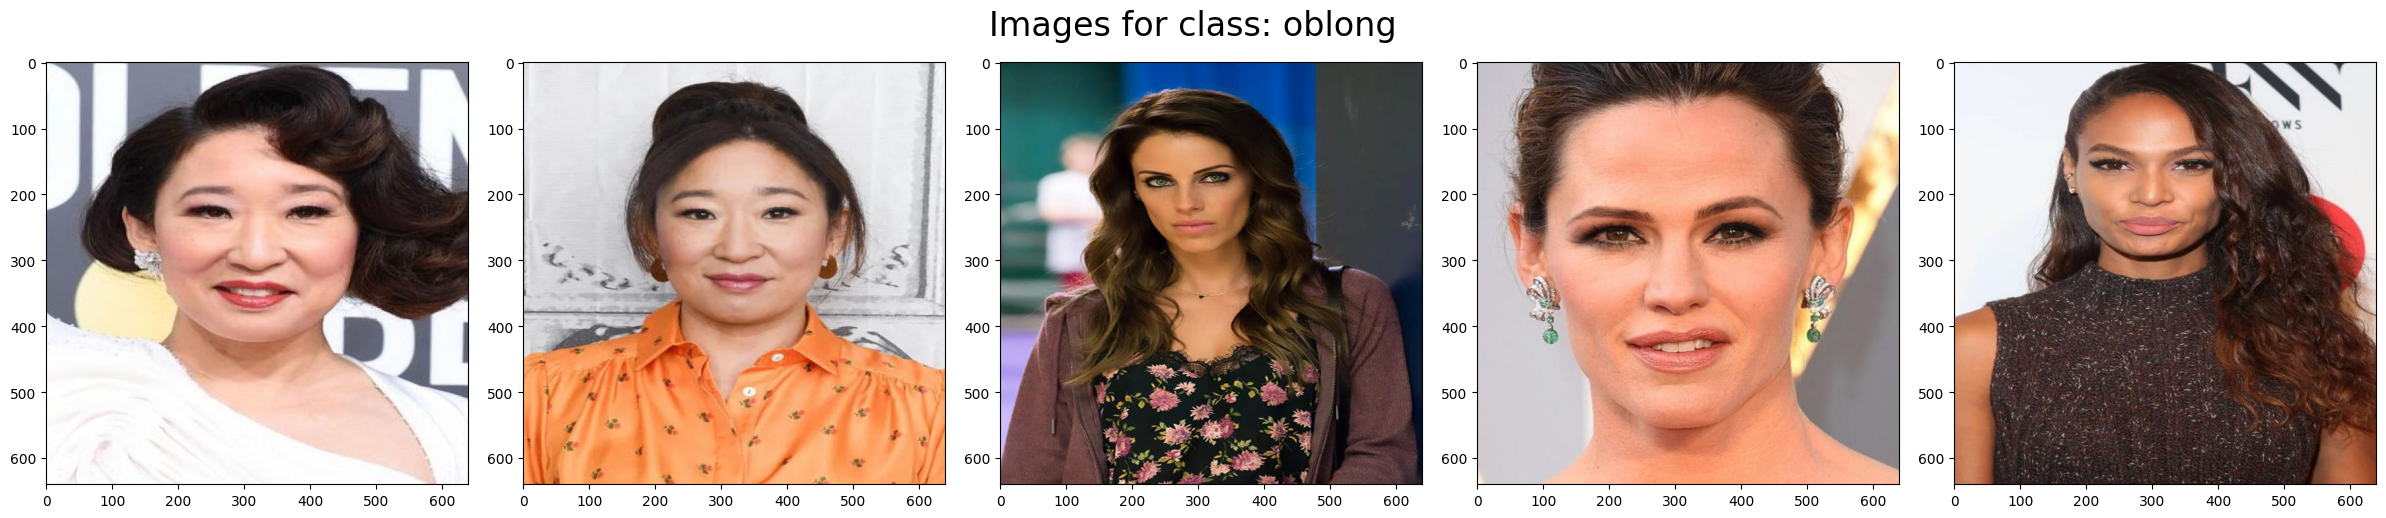

In [7]:
show_images_by_path(BASE, 'oblong')

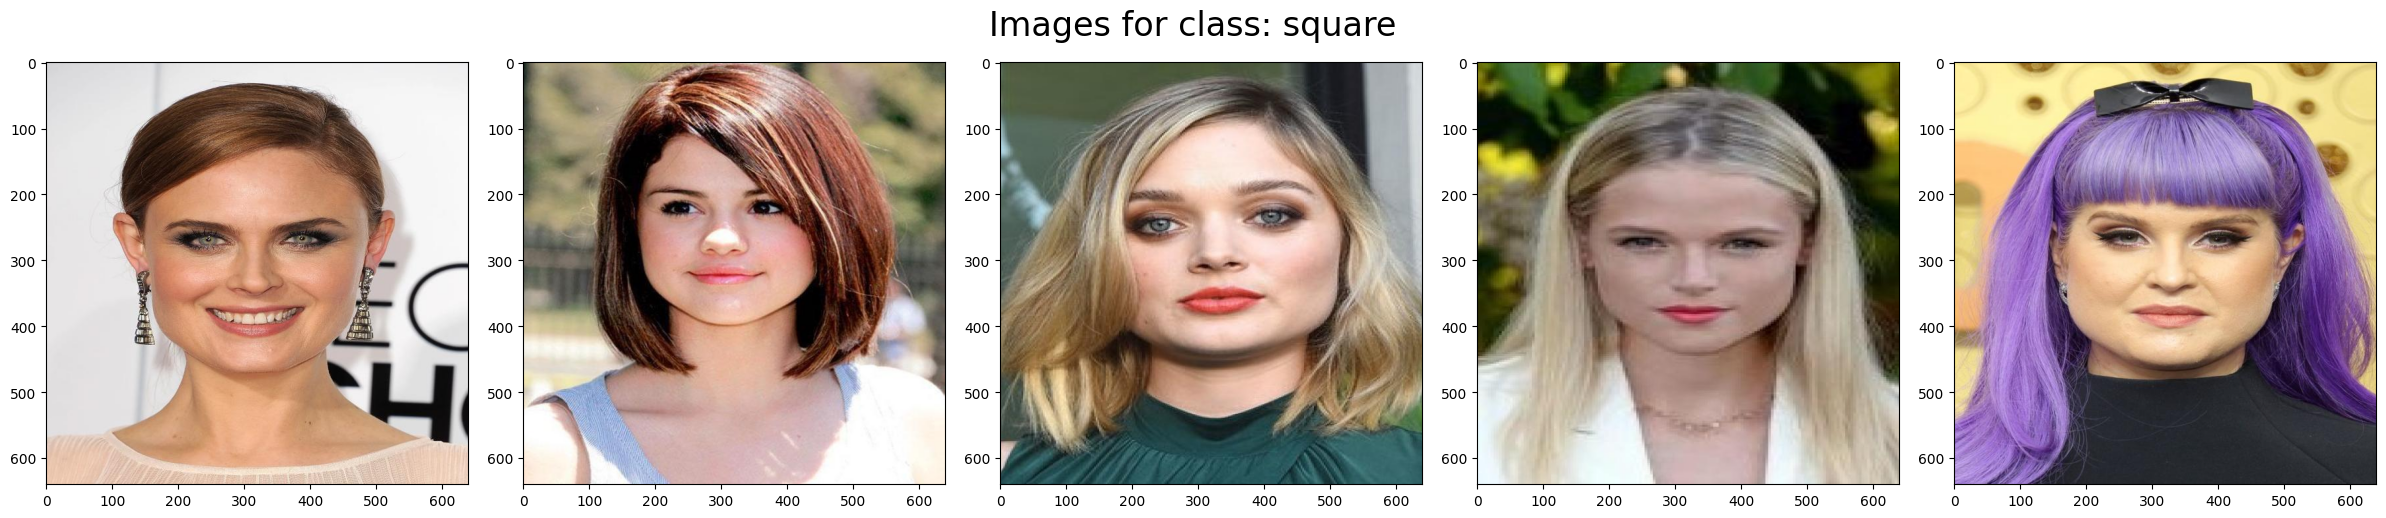

In [8]:
show_images_by_path(BASE, 'square')

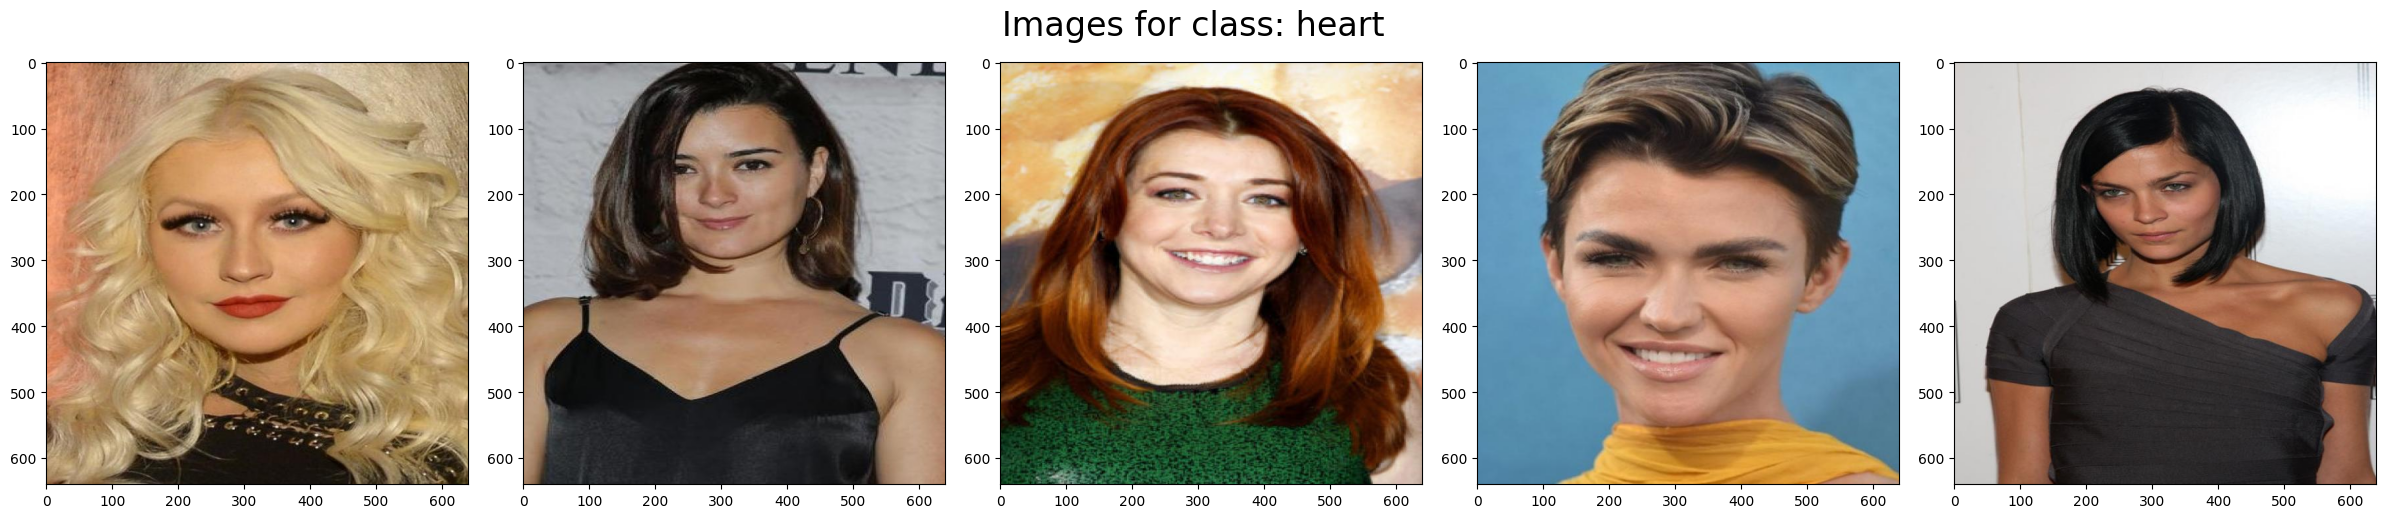

In [9]:
show_images_by_path(BASE, 'heart')

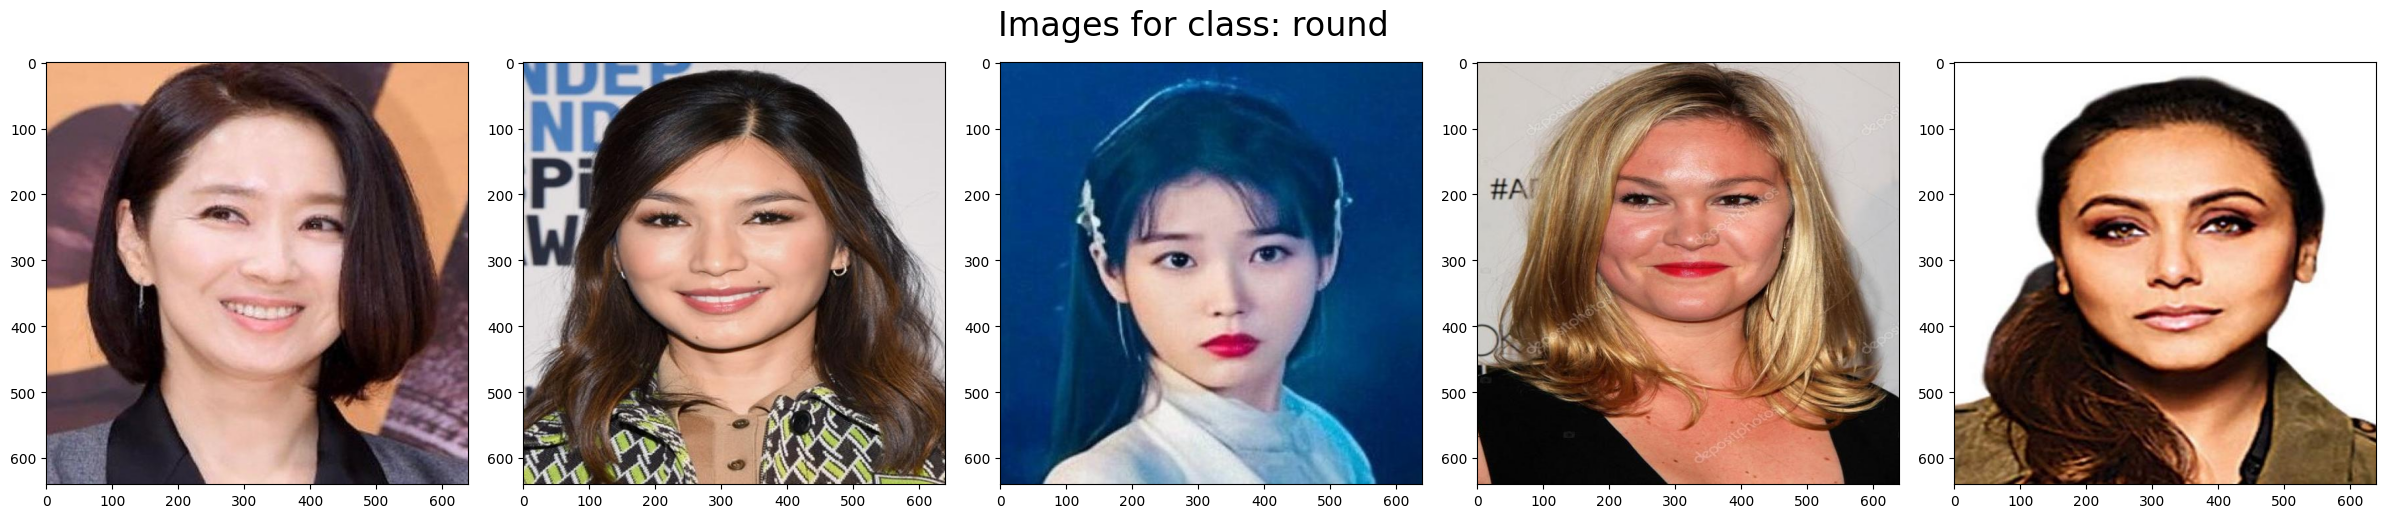

In [10]:
show_images_by_path(BASE, 'round')

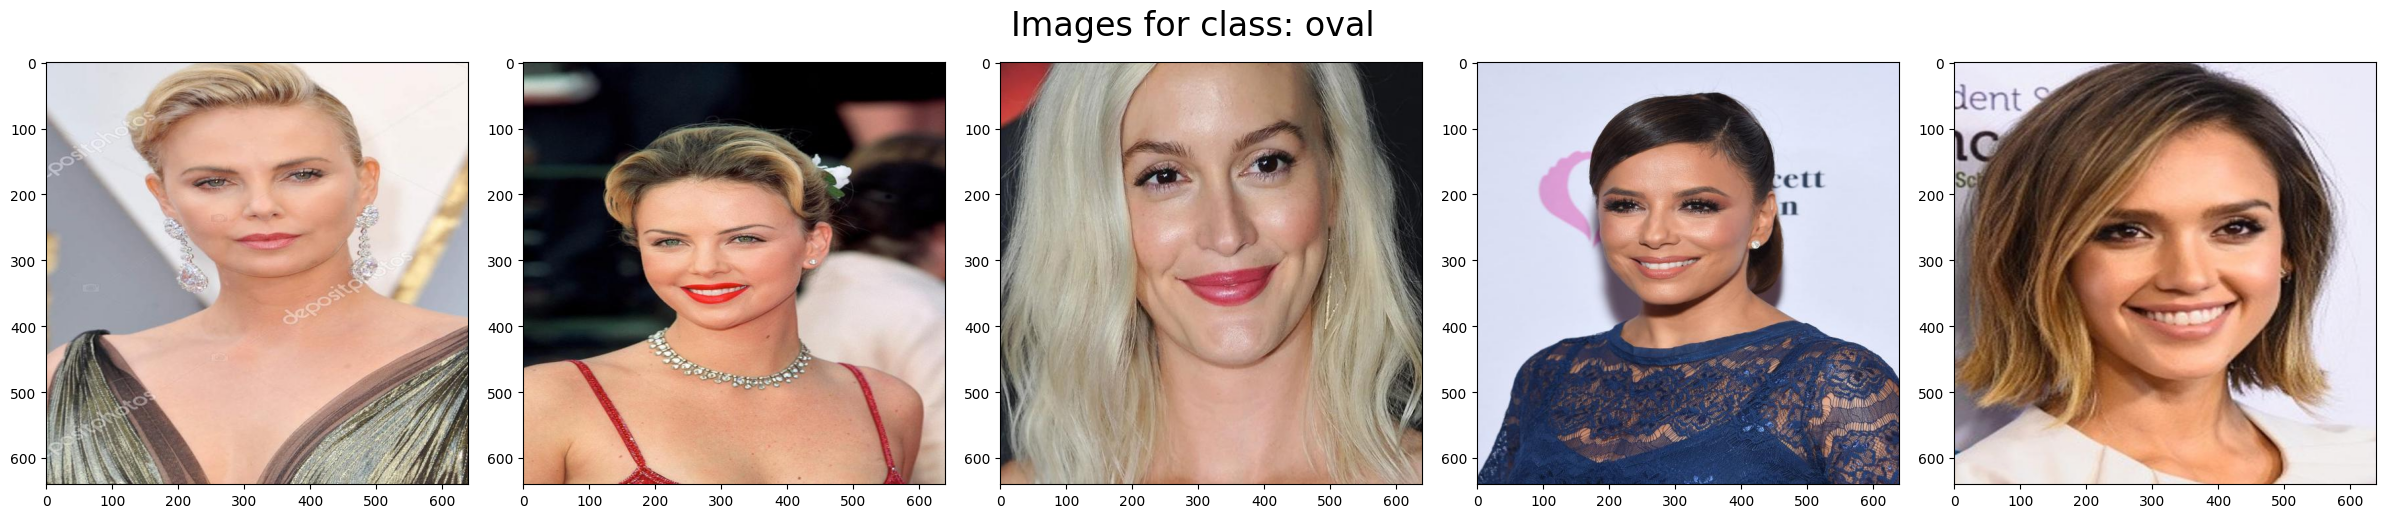

In [11]:
show_images_by_path(BASE, 'oval')

In [12]:
def get_unique_shapes(base_dir):
    labels = os.listdir(base_dir)
    for label in labels:
        label_dir = os.path.join(base_dir, label)
        if not os.path.isdir(label_dir):
            continue

        shapes = set()
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = load_img(img_path)
            shape = img_to_array(img).shape
            shapes.add(shape)

        print(f"Image shapes in label '{label}': {shapes}")

In [13]:
get_unique_shapes(BASE)

Image shapes in label 'oblong': {(640, 640, 3)}
Image shapes in label 'heart': {(640, 640, 3)}
Image shapes in label 'round': {(640, 640, 3)}
Image shapes in label 'square': {(640, 640, 3)}
Image shapes in label 'oval': {(640, 640, 3)}


In [14]:
def split_data(base_dir, train_dir, val_dir, test_dir, split_ratio=(0.6, 0.3, 0.1)):
    labels = os.listdir(base_dir)

    for label in labels:
        label_dir = os.path.join(base_dir, label)

        images = os.listdir(label_dir)
        train_images, temp_images = train_test_split(
            images,
            test_size=(1 - split_ratio[0]),
            random_state=42
        )
        val_images, test_images = train_test_split(
            temp_images,
            test_size=(split_ratio[2] / (split_ratio[1] + split_ratio[2])),
            random_state=42
        )

        for image in train_images:
            train_label_dir = os.path.join(train_dir, label)
            os.makedirs(train_label_dir, exist_ok=True)
            shutil.copy(os.path.join(label_dir, image), os.path.join(train_label_dir, image))

        for image in val_images:
            val_label_dir = os.path.join(val_dir, label)
            os.makedirs(val_label_dir, exist_ok=True)
            shutil.copy(os.path.join(label_dir, image), os.path.join(val_label_dir, image))

        for image in test_images:
            test_label_dir = os.path.join(test_dir, label)
            os.makedirs(test_label_dir, exist_ok=True)
            shutil.copy(os.path.join(label_dir, image), os.path.join(test_label_dir, image))


In [15]:
TRAIN_DIR = os.path.join(BASE, 'split_dataset/train_dir')
VAL_DIR = os.path.join(BASE, 'split_dataset/val_dir')
TEST_DIR = os.path.join(BASE, 'split_dataset/test_dir')

In [16]:
split_data(BASE, TRAIN_DIR, VAL_DIR, TEST_DIR, split_ratio=(0.75, 0.15, 0.1))

In [17]:
def plot_data_distribution(train_dir, val_dir, test_dir, labels):
    train_counts = []
    val_counts = []
    test_counts = []

    for label in labels:
        train_label_dir = os.path.join(train_dir, label)
        val_label_dir = os.path.join(val_dir, label)
        test_label_dir = os.path.join(test_dir, label)

        train_counts.append(len(os.listdir(train_label_dir)) if os.path.isdir(train_label_dir) else 0)
        val_counts.append(len(os.listdir(val_label_dir)) if os.path.isdir(val_label_dir) else 0)
        test_counts.append(len(os.listdir(test_label_dir)) if os.path.isdir(test_label_dir) else 0)

    x = range(len(labels))
    bar_width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x, train_counts, width=bar_width, label='Train', color='blue', align='center')
    ax.bar([p + bar_width for p in x], val_counts, width=bar_width, label='Validation', color='orange', align='center')
    ax.bar([p + 2*bar_width for p in x], test_counts, width=bar_width, label='Test', color='green', align='center')

    ax.set_xlabel('Labels')
    ax.set_ylabel('Jumlah Gambar')
    ax.set_title('Distribusi Jumlah Gambar')
    ax.set_xticks([p + bar_width for p in x])
    ax.set_xticklabels(labels)
    ax.legend()

    plt.tight_layout()
    plt.show()

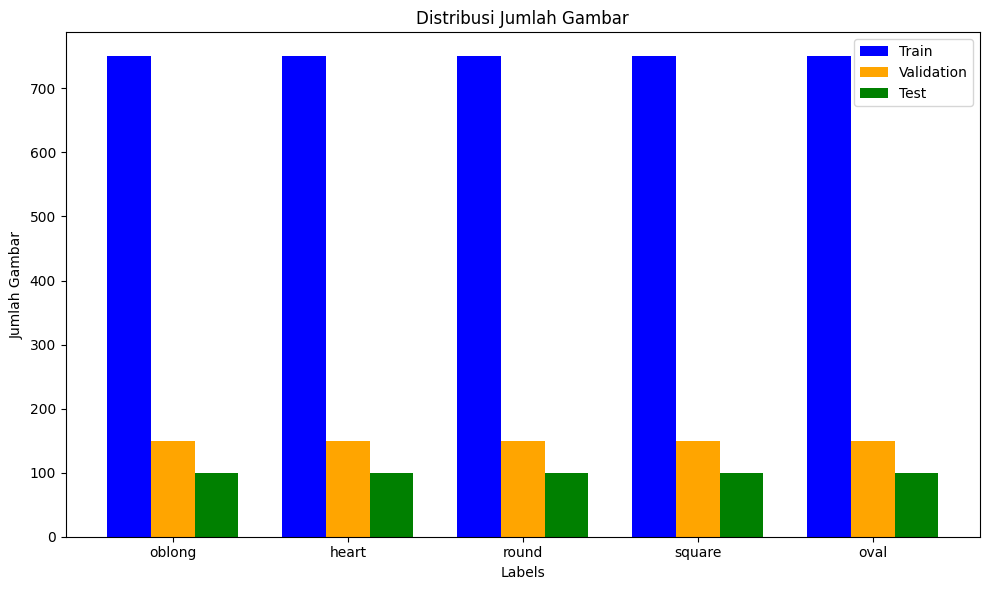

In [18]:
plot_data_distribution(TRAIN_DIR, VAL_DIR, TEST_DIR, labels)

#**Training**

In [39]:
# Hyperparameters
image_size = (224, 224)
batch_size = 32
seed = 42
learning_rate = 1e-5
epochs_0 = 100

In [40]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3750 images belonging to 5 classes.
Found 750 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [41]:
# print('Loading Xception ...')
# base_model = Xception(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet'
# )
# print('Xception loaded')

# print('Loading MobileNetV2 ...')
# base_model = MobileNetV2(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet',
# )
# print('MobileNetV2 loaded')

print('Loading ResNet50 ...')
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
print('ResNet50 loaded')

# print('Loading ResNet101 ...')
# base_model = ResNet101(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(224, 224, 3)
# )
# print('ResNet101 loaded')

Loading ResNet50 ...
ResNet50 loaded


In [42]:
# Name of layers in Xception
for layer in base_model.layers :
    print(layer.name)

input_layer_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn


In [43]:
base_model.trainable = False

set_trainable = False

for layer in base_model.layers :
    if layer.name == 'conv4_block1_1_conv' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [44]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(300, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.4)(x)
x = Dense(150, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.4)(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,248,317 (92.50 MB)

 Trainable params: 22,745,213 (86.77 MB)

 Non-trainable params: 1,503,104 (5.73 MB)

In [45]:
# Optimizer
# opt = RMSprop(learning_rate=learning_rate, rho=0.9, epsilon=1e-08)
opt = Adam(learning_rate = learning_rate)
# opt = SGD(learning_rate=learning_rate, momentum=0.9)

# Compilation
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model CheckPoint
checkpoint_cb = ModelCheckpoint('BestModel.keras', save_best_only=True)

# Early Stoping
class CustomEarlyStopping(Callback):
    def __init__(self, target_val_loss=0.5, patience=15):
        super(CustomEarlyStopping, self).__init__()
        self.target_val_loss = target_val_loss
        self.patience = patience
        self.best_val_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is not None:
            # Cek apakah val_loss mencapai target
            if val_loss <= self.target_val_loss:
                print(f"\nTarget validation loss {self.target_val_loss} tercapai. Menghentikan pelatihan...")
                self.model.stop_training = True

            # Cek apakah val_loss tidak meningkat dalam 'patience' iterasi
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.wait = 0  # Reset counter jika val_loss turun
            else:
                self.wait += 1  # Tambah counter jika val_loss tidak turun

                if self.wait >= self.patience:
                    print(f"\nValidation loss tidak turun selama {self.patience} epoch. Menghentikan pelatihan...")
                    self.model.stop_training = True


# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [46]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs_0,
    callbacks=[
        checkpoint_cb,
        CustomEarlyStopping(),
        reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/118 ━━━━━━━━━━━━━━━━━━━━ 122s 698ms/step - accuracy: 0.1960 - loss: 2.0425 - val_accuracy: 0.2827 - val_loss: 1.6589 - learning_rate: 1.0000e-05
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 63s 512ms/step - accuracy: 0.2399 - loss: 1.7739 - val_accuracy: 0.3293 - val_loss: 1.5795 - learning_rate: 1.0000e-05
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 67s 546ms/step - accuracy: 0.2820 - loss: 1.6779 - val_accuracy: 0.3813 - val_loss: 1.5140 - learning_rate: 1.0000e-05
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 85s 575ms/step - accuracy: 0.3258 - loss: 1.6005 - val_accuracy: 0.4240 - val_loss: 1.4498 - learning_rate: 1.0000e-05
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 62s 504ms/step - accuracy: 0.3787 - loss: 1.5281 - val_accuracy: 0.4667 - val_loss: 1.3823 - learning_rate: 1.0000e-05
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 66s 538ms/step - accuracy: 0.4148 - loss: 1.4738 - val_accuracy: 0.5013 - val_loss: 1.3312 - learning_rate: 1.0000e-05
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 60s 484ms/

In [47]:
model.save('MyModel.keras')

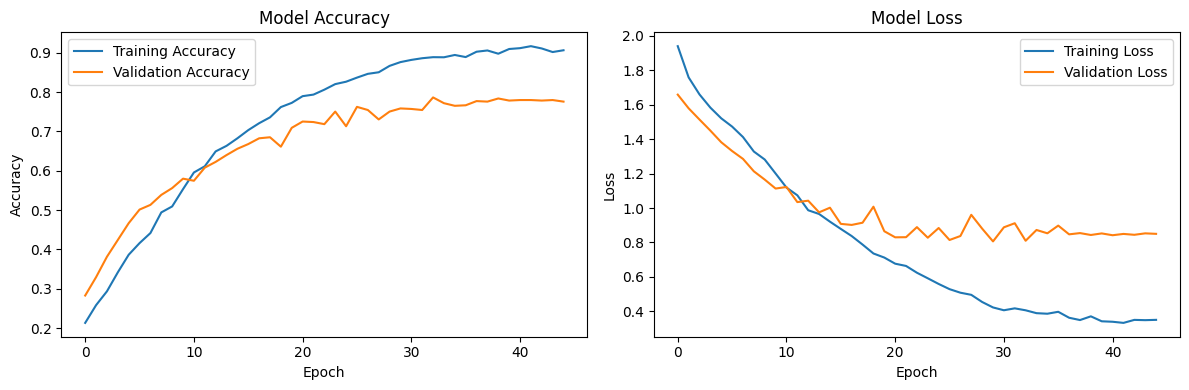

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Testing**

In [49]:
final_model = load_model('MyModel.keras')
final_model.evaluate(test_generator, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.8011 - loss: 0.7486


[0.7538883090019226, 0.7960000038146973]

In [50]:
best_model = load_model('BestModel.keras')
best_model.evaluate(test_generator, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.7891 - loss: 0.7396


[0.730707049369812, 0.7739999890327454]

In [51]:
# selected_images = []
# selected_labels = []
# selected_true_classes = []

# while len(selected_images) < 5:
#     image_batch, labels_batch = next(test_generator)
#     true_classes = labels_batch.argmax(axis=1)

#     for i in range(len(image_batch)):
#         if len(selected_images) >= 5:
#             break
#         if true_classes[i] not in selected_true_classes:
#             selected_images.append(image_batch[i])
#             selected_labels.append(labels_batch[i])
#             selected_true_classes.append(true_classes[i])

# predictions = model.predict(np.array(selected_images), verbose=0)
# predicted_classes = predictions.argmax(axis=1)

# class_names = list(test_generator.class_indices.keys())

# fig, axes = plt.subplots(1, 5, figsize=(15, 5))
# for i, ax in enumerate(axes):
#     ax.imshow(selected_images[i])
#     ax.set_title(f"True: {class_names[selected_true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}", fontsize=12)
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

In [52]:
predictions1 = model.predict(test_generator, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 304ms/step


In [53]:
predictions2 = best_model.predict(test_generator, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 356ms/step


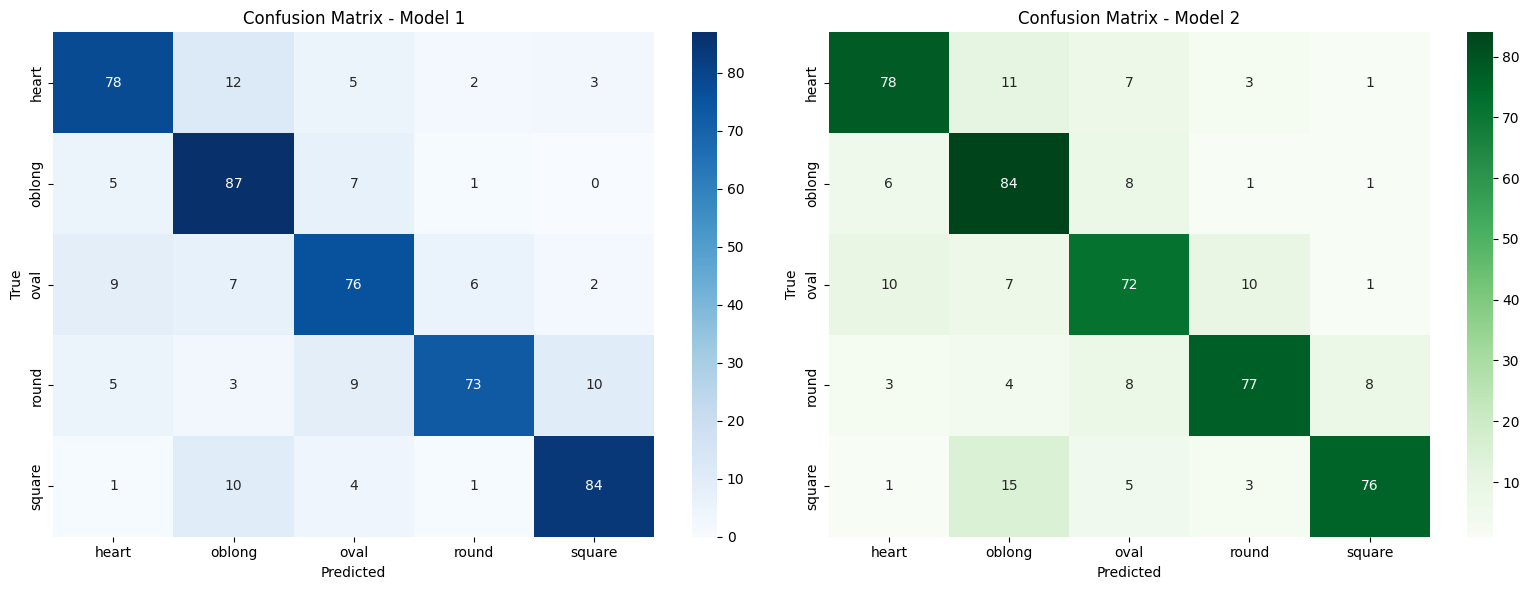

In [54]:
# Confusion Matrices
cm1 = confusion_matrix(test_generator.classes, np.argmax(predictions1, axis=1))
cm2 = confusion_matrix(test_generator.classes, np.argmax(predictions2, axis=1))

# Visualisasi kedua confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix for predictions1
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
axes[0].set_title('Confusion Matrix - Model 1')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Confusion Matrix for predictions2
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
axes[1].set_title('Confusion Matrix - Model 2')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Tampilkan plot
plt.tight_layout()
plt.show()

In [55]:
predicted_classes = np.argmax(predictions1, axis=1)
true_classes = test_generator.classes

report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

       heart       0.80      0.78      0.79       100
      oblong       0.73      0.87      0.79       100
        oval       0.75      0.76      0.76       100
       round       0.88      0.73      0.80       100
      square       0.85      0.84      0.84       100

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



In [56]:
predicted_classes = np.argmax(predictions2, axis=1)
true_classes = test_generator.classes

report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

       heart       0.80      0.78      0.79       100
      oblong       0.69      0.84      0.76       100
        oval       0.72      0.72      0.72       100
       round       0.82      0.77      0.79       100
      square       0.87      0.76      0.81       100

    accuracy                           0.77       500
   macro avg       0.78      0.77      0.77       500
weighted avg       0.78      0.77      0.77       500



In [57]:
import pickle

history_dict = history.history
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
import shutil

shutil.make_archive('model_and_history', 'zip', '.', '.')

In [ ]:
from google.colab import files

files.download('model_and_history.zip')